In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import statsmodels.api as sm
from sklearn.linear_model import HuberRegressor


In [2]:
# Load the data

In [3]:
output = pd.read_excel("/data_hdd1/yang/Source_data/Fig_3/Fig_3b.xlsx", index_col=0)

### Figure 3B

/tmp/ipykernel_2035647/2634790274.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y="FCER1G_directed_genes", data=output, palette=palette)


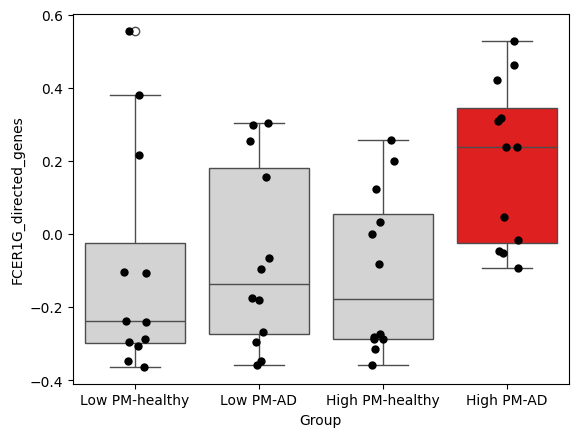

In [4]:

# Merge data to include only the 'Group' column and 'FCER1G_directed_genes'

# Define a custom palette for the 'Group' column
palette = {group: 'red' if group == 'High PM-AD' else 'lightgray' for group in output['Group'].unique()}

# Create boxplot and stripplot for visualization
sns.boxplot(x='Group', y="FCER1G_directed_genes", data=output, palette=palette)
sns.stripplot(x='Group', y="FCER1G_directed_genes", data=output, color='black', size=6, jitter=True)

# Display the plot
plt.show()

# Save the plot if needed
#plt.savefig('/home/yang/PM_AD/Submission/Figure_3/Figure3B/Figure_3B.pdf', dpi=300, bbox_inches='tight')


In [5]:
# Perform Wilcoxon rank-sum test between two groups
def wilcox_ranksum_test(tmp1, Case, Control):
    df = tmp1.copy()
    
    # Subset data for Case and Control
    group_Case = df[df['Group'] == Case]
    group_Control = df[df['Group'] == Control]
    
    p_values, t_values = [], []

    # Perform Wilcoxon rank-sum test for each column
    for column in group_Case.columns:
        if column != 'Group':  # Exclude the 'Group' column
            statistic, p_value = ranksums(group_Case[column], group_Control[column])
            p_values.append(p_value)
            t_values.append(statistic)
    
    # Return a DataFrame with p-values and t-values
    return pd.DataFrame({"P": p_values, "T": t_values}, index=group_Case.columns)


In [6]:
# Perform Wilcoxon rank-sum test for different comparisons
wilcox_ranksum_test(output, 'High PM-AD', 'High PM-healthy')

,P,T
Group,0.007912,2.655811
FCER1G_directed_genes,0.007912,2.655811


In [7]:
wilcox_ranksum_test(output, 'High PM-AD', 'Low PM-AD')

,P,T
Group,0.009375,2.598076
FCER1G_directed_genes,0.009375,2.598076


In [8]:
wilcox_ranksum_test(output, 'High PM-AD', 'Low PM-healthy')

,P,T
Group,0.007912,2.655811
FCER1G_directed_genes,0.007912,2.655811


### Figure 3C - Linear Regression with Robust Methods

In [9]:
# Load the Clinical data
Clinic_cor = pd.read_excel("/data_hdd1/yang/Source_data/Fig_3/Fig_3c.xlsx",index_col=0)

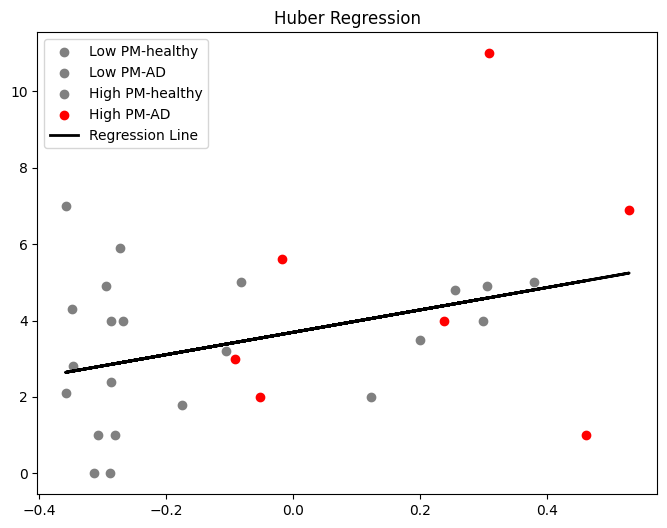

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor

# Set matplotlib figure size and font type for saving as PDF
plt.rcParams["figure.figsize"] = (8, 6)  # Set figure size
plt.rcParams['pdf.fonttype'] = 42  # Set font type to allow editing in PDF

# Select the necessary columns from the Clinic_cor DataFrame
x = Clinic_cor['FCER1G_directed_genes']
y = Clinic_cor['Cord blood eosinophil count']
groups = Clinic_cor['Group']  # Extract the 'Group' column

# Remove NaN values from x, y, and groups
valid_indices = np.isfinite(x) & np.isfinite(y)
x = x[valid_indices].values.reshape(-1, 1)
y = y[valid_indices]
groups = groups[valid_indices]

# Create HuberRegressor model and fit it
model = HuberRegressor()
model.fit(x, y)

# Define group labels and assign colors for each group
group_labels = groups.unique()
colors = ['grey', 'grey', 'grey', 'red']  # Color mapping for groups (default grey, G4 in red)

# Scatter plot for each group
for i, group_label in enumerate(group_labels):
    group_x = x[groups == group_label]
    group_y = y[groups == group_label]
    plt.scatter(group_x, group_y, color=colors[i], label=group_label)

# Plot the regression line
plt.plot(x, model.predict(x), color='black', linewidth=2, label='Regression Line')

# Add title and legend to the plot
plt.title('Huber Regression')
plt.legend()

# Display the plot
plt.show()


In [11]:
# Extract the relevant columns for regression analysis
x = Clinic_cor["FCER1G_directed_genes"]
y = Clinic_cor["Cord blood eosinophil count"]

# Remove NaN values for both variables
valid_indices = np.isfinite(x) & np.isfinite(y)
x = x[valid_indices].values.reshape(-1, 1)
y = y[valid_indices]

# Fit a robust linear model using Huber T norm
rlm_model = sm.RLM(y, sm.add_constant(x), M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()

# Display results of the regression model
print(f"p-value: {rlm_results.pvalues[1]}")
print(rlm_results.summary())


p-value: 0.04231232055125665
                         Robust linear Model Regression Results                        
Dep. Variable:     Cord blood eosinophil count   No. Observations:                   29
Model:                                     RLM   Df Residuals:                       27
Method:                                   IRLS   Df Model:                            1
Norm:                                   HuberT                                         
Scale Est.:                                mad                                         
Cov Type:                                   H1                                         
Date:                         Mon, 24 Feb 2025                                         
Time:                                 18:21:12                                         
No. Iterations:                             13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------

/tmp/ipykernel_2035647/2438667313.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"p-value: {rlm_results.pvalues[1]}")


### Figure 3D

In [12]:
Clinical = pd.read_excel("/data_hdd1/yang/Source_data/Fig_3/Fig_3d.xlsx",index_col=0)

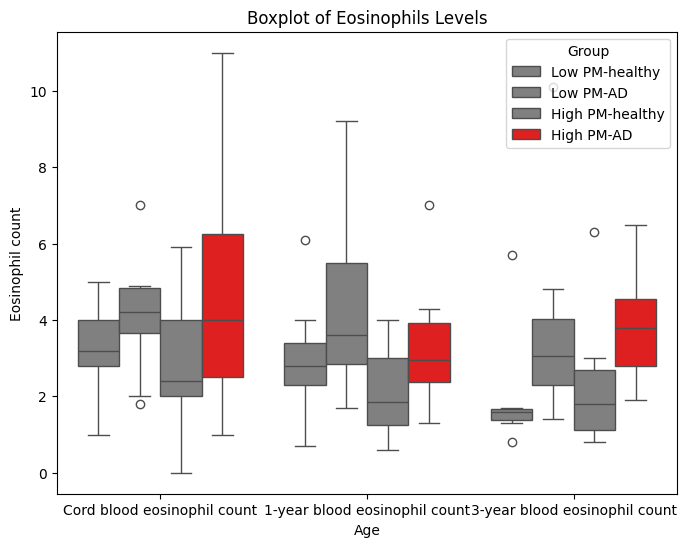

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

melted = pd.melt(Clinical, id_vars=['Group'], value_vars=['Cord blood eosinophil count', '1-year blood eosinophil count', '3-year blood eosinophil count'],
                 var_name='Age', value_name='Eosinophil count')

# Group에 따른 색상 지정
palette = {"High PM-AD":"red", "High PM-healthy":"grey","Low PM-AD": "grey", "Low PM-healthy": "grey"}

# boxplot 그리기
plt.figure(figsize=(8, 6))
sns.boxplot(x='Age', y='Eosinophil count', hue='Group', data=melted, palette=palette)
plt.title('Boxplot of Eosinophils Levels')

# plt.savefig("/home/yang/PM_AD/Submission/Figure_3/Figure3C/Eosinophil_Boxplot.pdf", format='pdf')

# 그래프 출력
plt.show()